In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model

In [ ]:

import os

cache_dir = "..." #replace this
os.makedirs(cache_dir, exist_ok=True)

from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_name = "pedramyazdipoor/parsbert_question_answering_PQuAD"

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, cache_dir=cache_dir)

In [ ]:
### load model

from transformers import AutoTokenizer, AutoModelForQuestionAnswering

cache_dir = "..." # replace this
model_name = "pedramyazdipoor/parsbert_question_answering_PQuAD"

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, cache_dir=cache_dir)

Some weights of the model checkpoint at pedramyazdipoor/parsbert_question_answering_PQuAD were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at pedramyazdipoor/parsbert_question_answering_PQuAD and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be 

In [ ]:
print(model)

# **ParsBERT for Persian Question Answering**

## Model Architecture

This model is based on the `BertForQuestionAnswering` architecture, which consists of:

### Embedding Layer
- **Word Embeddings**: `Embedding(100000, 768)` — vocab size of 100,000 with hidden size 768.
- **Position Embeddings**: `Embedding(512, 768)` — supports input sequences up to 512 tokens.
- **Token Type Embeddings**: `Embedding(2, 768)` — distinguishes between question and context segments.
- Includes `LayerNorm` and `Dropout` for normalization and regularization.

### Encoder (12-layer Transformer)
- A stack of 12 `BertLayer` blocks, each containing:
  - **Multi-head Self-Attention** with SDPA (Scaled Dot-Product Attention).
  - **Feedforward Layer** with a hidden size of 3072 and GELU activation.
  - `LayerNorm` and `Dropout` applied at appropriate stages.

### Output Head
- `qa_outputs`: A linear layer mapping the final hidden state to two logits for:
  - Start position of the answer span.
  - End position of the answer span.



In [ ]:
!pip install evaluate

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, default_data_collator
from datasets import load_dataset, DatasetDict, Dataset
import torch
import json
import numpy as np
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from transformers import pipeline
import evaluate
from evaluate import load
from sklearn.metrics import f1_score
import json
from collections import defaultdict
from difflib import SequenceMatcher


# **First Evaluation (on pQuAD data)**

In [ ]:


def load_pqa(path):
    with open(path, encoding='utf-8') as f:
        data = json.load(f)

    samples = []
    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                question = qa["question"]
                id_ = qa["id"]
                answers = qa["answers"]
                answer_texts = [ans["text"] for ans in answers]
                answer_starts = [ans["answer_start"] for ans in answers]
                samples.append({
                    "id": id_,
                    "context": context,
                    "question": question,
                    "answers": {
                        "text": answer_texts,
                        "answer_start": answer_starts
                    }
                })
    return samples

train_samples = load_pqa("...") #replace this
test_samples  = load_pqa("...") #replace this

# Split training set for validation
#train_data, val_data = train_test_split(train_samples, test_size=0.1, random_state=42)

'''
dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data),
    "test": Dataset.from_list(test_samples)
})
'''
'''
# ✅ Filter answerable samples only
def is_answerable(sample):
    return len(sample["answers"]["answer_start"]) > 0 and sample["answers"]["text"][0].strip() != ""

answerable_train_samples = [s for s in train_samples if is_answerable(s)]

'''
dataset = DatasetDict({
    "train": Dataset.from_list(train_samples),
    "test": Dataset.from_list(test_samples)
})

# 🧪 Preprocessing function for QA
def preprocess(example):
    questions = [q.strip() for q in example["question"]]
    contexts = example["context"]
    answers_list = example["answers"]

    tokenized = tokenizer(
        questions,
        contexts,
        max_length=384,
        stride=64,
        truncation="only_second",
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized.sequence_ids(i)
        sample_idx = sample_mapping[i]
        answers = answers_list[sample_idx]

        if len(answers["answer_start"]) == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                start_positions.append(token_start_index - 1)

                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                end_positions.append(token_end_index + 1)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    return tokenized


# 🔄 Apply preprocessing
tokenized_datasets = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)



Map: 100%|██████████| 8002/8002 [00:01<00:00, 4121.30 examples/s]


In [ ]:


def freeze_all_bert_layers(model):
    for param in model.bert.parameters():
        param.requires_grad = False

    for param in model.qa_outputs.parameters():
        param.requires_grad = True

def unfreeze_last_n_layers(model, n):
    for layer in model.bert.encoder.layer[-n:]:
        for param in layer.parameters():
            param.requires_grad = True



train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=16, shuffle=True, collate_fn=default_data_collator)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

freeze_all_bert_layers(model)
unfreeze_last_n_layers(model,2)

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                  lr=2e-5)
model.to(device)

In [ ]:

def focal_loss(logits, targets, gamma=2.0, reduction='mean'):
    log_probs = F.log_softmax(logits, dim=-1)
    probs = torch.exp(log_probs)
    target_log_probs = log_probs.gather(dim=-1, index=targets.unsqueeze(-1)).squeeze(-1)
    target_probs = probs.gather(dim=-1, index=targets.unsqueeze(-1)).squeeze(-1)

    loss = -((1 - target_probs) ** gamma) * target_log_probs
    return loss.mean() if reduction == 'mean' else loss

def qa_focal_loss(start_logits, end_logits, start_positions, end_positions, gamma=2.0):
    start_loss = focal_loss(start_logits, start_positions, gamma=gamma)
    end_loss = focal_loss(end_logits, end_positions, gamma=gamma)
    return (start_loss + end_loss) / 2

##########

def make_binary_targets(positions, seq_len):
    # positions: (batch,)
    # returns: (batch, seq_len)
    batch_size = positions.size(0)
    binary = torch.zeros((batch_size, seq_len), device=positions.device)
    binary[torch.arange(batch_size), positions] = 1.0
    return binary

def loss_fn(out1,out2,target1,target2):
  l1 = nn.BCEWithLogitsLoss()(out1, target1.float())
  l2 = nn.BCEWithLogitsLoss()(out2, target2.float())
  return l1 + l2

num_epochs = 1

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    model.train()
    totall_loss = 0

    progress_bar = tqdm(train_dataloader)
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        '''
        outputs = model(**batch)
        loss = outputs.loss


        outputs = model(**batch)
        loss = qa_focal_loss(
            outputs.start_logits,
            outputs.end_logits,
            batch["start_positions"],
            batch["end_positions"],
            gamma=1.6
        )
        '''

        outputs = model(**batch)
        start_logits = outputs.start_logits  # shape: (batch, seq_len)
        end_logits = outputs.end_logits

        seq_len = start_logits.size(1)


        target_start = make_binary_targets(batch["start_positions"], seq_len)
        target_end = make_binary_targets(batch["end_positions"], seq_len)

        loss = loss_fn(start_logits, end_logits, target_start, target_end)


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        totall_loss += loss.item()
        progress_bar.set_description(f"Loss: {loss.item():.4f}")

    avg_loss = totall_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")


Epoch 1/1


Loss: 0.0070: 100%|██████████| 4000/4000 [34:01<00:00,  1.96it/s]

Epoch 1 average loss: 0.0162


In [ ]:
# test

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


with open("datset/pQuad/Test.json", encoding="utf-8") as f:
    squad_data = json.load(f)

def squad_to_dataset(squad_dict):
    data = []
    for article in squad_dict['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                data.append({
                    'id': qa['id'],
                    'context': context,
                    'question': qa['question'],
                    'answers': {
                        'text': [a['text'] for a in qa['answers']],
                        'answer_start': [a['answer_start'] for a in qa['answers']],
                    }
                })
    return Dataset.from_list(data)

raw_dataset = squad_to_dataset(squad_data)

def preprocess_test(example):
    tokenized = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=384,
        stride=64,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    tokenized["example_id"] = []
    tokenized["offset_mapping_fixed"] = []

    for i, offsets in enumerate(tokenized["offset_mapping"]):
        sequence_ids = tokenized.sequence_ids(i)
        context_offsets = [o if sequence_ids[k] == 1 else None for k, o in enumerate(offsets)]
        tokenized["offset_mapping_fixed"].append(context_offsets)
        tokenized["example_id"].append(example["id"][sample_mapping[i]])

    return tokenized

tokenized_dataset = raw_dataset.map(preprocess_test, batched=True, remove_columns=raw_dataset.column_names)

features_per_example = defaultdict(list)
for i, ex_id in enumerate(tokenized_dataset["example_id"]):
    features_per_example[ex_id].append(i)


def collate_fn(batch):
    return {
        "input_ids": torch.tensor([f["input_ids"] for f in batch]),
        "attention_mask": torch.tensor([f["attention_mask"] for f in batch]),
        "offset_mapping": [f["offset_mapping_fixed"] for f in batch],
        "example_id": [f["example_id"] for f in batch],
    }

dataloader = DataLoader(tokenized_dataset, batch_size=32, collate_fn=collate_fn)

start_logits_all, end_logits_all = [], []

for batch in tqdm(dataloader, desc="Running inference"):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        start_logits_all.extend(outputs.start_logits.cpu().numpy())
        end_logits_all.extend(outputs.end_logits.cpu().numpy())

n_best_size = 20
max_answer_length = 30
null_score_diff_threshold = 0.0

predictions = {}
for example in raw_dataset:
    example_id = example["id"]
    context = example["context"]
    feature_indices = features_per_example[example_id]

    valid_answers = []
    cls_scores = []

    for idx in feature_indices:
        start_logits = start_logits_all[idx]
        end_logits = end_logits_all[idx]
        offset_mapping = tokenized_dataset[idx]["offset_mapping_fixed"]
        input_ids = tokenized_dataset[idx]["input_ids"]

        cls_score = start_logits[0] + end_logits[0]
        cls_scores.append(cls_score)

        for start_idx in range(len(start_logits)):
            for end_idx in range(start_idx, min(start_idx + max_answer_length, len(end_logits))):
                if offset_mapping[start_idx] is None or offset_mapping[end_idx] is None:
                    continue

                score = start_logits[start_idx] + end_logits[end_idx]
                start_char = offset_mapping[start_idx][0]
                end_char = offset_mapping[end_idx][1]

                if start_char is not None and end_char is not None:
                    answer_text = context[start_char:end_char].strip()
                    valid_answers.append({
                        "score": score,
                        "text": answer_text,
                        "start": start_char,
                        "end": end_char
                    })

    if valid_answers:
        best_answer = max(valid_answers, key=lambda x: x["score"])
        max_score = best_answer["score"]
    else:
        best_answer = {"text": "", "score": -float("inf")}
        max_score = -float("inf")

    cls_score = max(cls_scores)
    if cls_score > max_score + null_score_diff_threshold:
        predictions[example_id] = {"id": example_id, "prediction_text": "", "no_answer_probability": 1.0}
    else:
        predictions[example_id] = {
            "id": example_id,
            "prediction_text": best_answer["text"],
            "no_answer_probability": 0.0
        }

references = [{
    "id": str(example["id"]),
    "answers": {
        "text": [a.replace("\u200c", "") for a in example["answers"]["text"]],
        "answer_start": example["answers"]["answer_start"]
    }
} for example in raw_dataset]

# Evaluate
metric = evaluate.load("squad_v2")
results = metric.compute(predictions=list(predictions.values()), references=references)

print(f"Exact Match: {results['exact']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")


Running inference: 100%|██████████| 251/251 [03:29<00:00,  1.20it/s]


Exact Match: 46.08
F1 Score: 54.46


In [ ]:
# Pick a random sample
sample = random.choice(test_dataset)

context = sample['context']
question = sample['question']
true_answers = sample['answers']['text']
true_answer = true_answers[0] if true_answers else ""


result = qa_pipeline({'question': question, 'context': context})
predicted_answer = result['answer']


exact_match = int(predicted_answer.strip() == true_answer.strip())


def compute_f1(pred, truth):
    pred_tokens = pred.strip().split()
    truth_tokens = truth.strip().split()
    common = set(pred_tokens) & set(truth_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * (precision * recall) / (precision + recall)

f1 = compute_f1(predicted_answer, true_answer)

print("\n--- RANDOM SAMPLE ---")
print(f"📌 Question: {question}")
print(f"📚 Context: {context}")
print(f"✅ True Answer: {true_answer}")
print(f"🤖 Model Prediction: {predicted_answer}")
print(f"📈 Exact Match (EM): {exact_match}")
print(f"📉 F1 Score: {f1:.2f}")


--- RANDOM SAMPLE ---
📌 Question: سیاست استراحت ابتکاری در گوگل اولین بار توسط چه کسی مطرح شد؟
📚 Context: گوگل به عنوان یک عامل ترغیب، سیاستی با نام «استراحت ابتکاری» (Innovation Time Off) در شرکتش به وجود آورد، که در آن مهندسان ۲۰٪ از زمان کار خود را به پروژه‌هایی اختصاص می‌دهند که به آن‌ها علاقه دارند. تعدادی از خدمات جدیدتر گوگل از جمله جی‌میل، گوگل نیوز، اورکات و ادسنس در اصل از همین ایده به وجود...
✅ True Answer: 
🤖 Model Prediction: مریسا مایر
📈 Exact Match (EM): 0
📉 F1 Score: 0.00


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\pipelines\question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


## First Evaluation and Next Steps

The model used in this project was originally fine-tuned on the PQuAD dataset and published on the Hugging Face Hub. However, upon loading the model, we encountered a warning indicating that the question answering head (`qa_outputs`) was not properly saved. This means that while the core BERT encoder layers were correctly restored, the classification layer responsible for predicting answer spans was randomly initialized. As a result, evaluation on the PQuAD test set yielded unreasonably low F1 and EM scores, which do not reflect the model's true potential.

Given this situation, we cannot trust the current evaluation results on PQuAD, since the model is essentially missing its fine-tuned QA capabilities. Re-training the QA head on PQuAD might help recover its original performance, but it is not strictly necessary. The key insight is that the transformer layers—the part of the model responsible for understanding Persian language—have already been trained on PQuAD. This deep representation can still be valuable for downstream tasks, even if the classification head needs to be retrained.

Therefore, instead of re-tuning the model on PQuAD, we can move directly to fine-tuning it on a new dataset such as PersianQA. During this process, the QA head will be trained from scratch on PersianQA examples, while the underlying encoder layers provide strong contextual understanding from previous training. This approach saves time and allows us to adapt the model to a new domain without redundant re-training on PQuAD.



# **Fine Tune on PersianQA**

## **Methods and Results**

## **Method 1.Fine-Tuning Strategies for Transformer QA Model**


### Gradual Layer Unfreezing During Training
- **What**: Start training with most layers frozen, and progressively unfreeze more layers as training proceeds (e.g., N layer every 1 epoch).
- **Pros**:
  - Efficient and dynamic.
  - Stabilizes training and reduces overfitting risk.
- **Why We Chose It**:
  - It adapts learning capacity over time.
  - Good real-world performance with less hyperparameter tuning.

- **Results:**
  - **F1 Score: 69.33**  
  - **Exact Match (EM): 53.55**  
  - **No-Answer F1: 70.6**



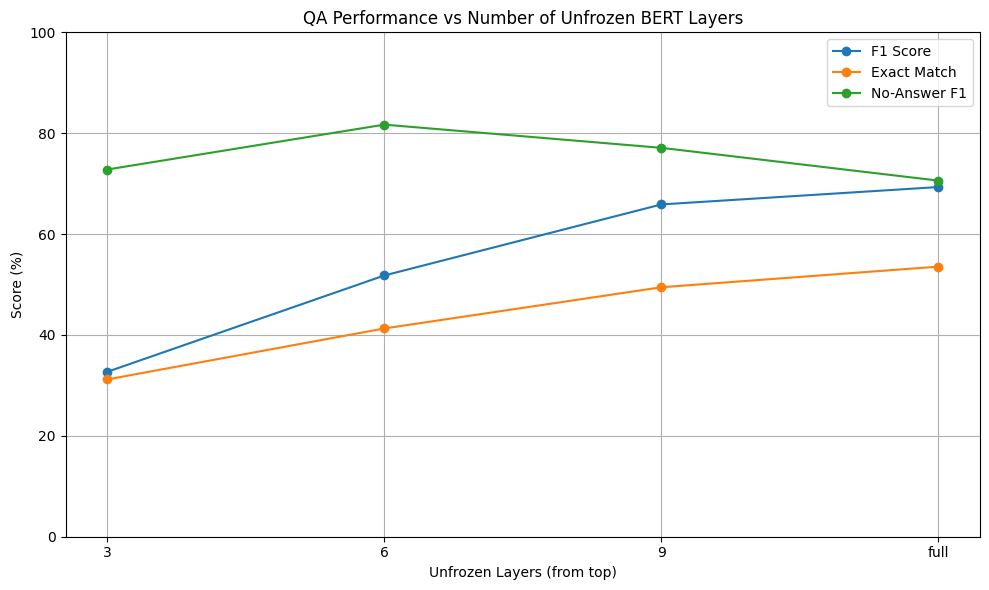

In [ ]:
import matplotlib.pyplot as plt

x_labels = ['3', '6', '9', 'full']

f1_scores = [32.69, 51.79, 65.88, 69.33]
em_scores = [31.18, 41.29, 49.46, 53.55]
noans_f1_scores = [72.8, 81.7, 77.1, 70.6]

plt.figure(figsize=(10, 6))
plt.plot(x_labels, f1_scores, marker='o', label='F1 Score')
plt.plot(x_labels, em_scores, marker='o', label='Exact Match')
plt.plot(x_labels, noans_f1_scores, marker='o', label='No-Answer F1')

plt.title('QA Performance vs Number of Unfrozen BERT Layers')
plt.xlabel('Unfrozen Layers (from top)')
plt.ylabel('Score (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




### **Method 2.Stepwise Fine-Tuning Strategy**

I used a stepwise fine-tuning approach to improve question answering performance.  
The process began with training only on answerable questions, and then I explored two different strategies to continue training on the full dataset.

I trained the model using only **answerable samples** from the dataset.  
This allowed the model to focus on span prediction without being confused by unanswerable cases.

**Base Model Results:**
  - **Has-Ans F1 Score: 73.1**  
  - **Has-Ans Exact Match (EM): 47**  
  - **No-Answer F1: 6.1**
---


 - **Approach 1: Continue Fine-Tuning on Full Dataset**

  I took the previously trained model (on answerable data) and continued fine-tuning it on the complete dataset.

  However, this method **did not improve results** compared to training on the full dataset from the beginning.

  **Results:**
  - **F1 Score: 69.33**  
  - **Exact Match (EM): 53.55**  
  - **No-Answer F1: 70.6**

---

 - **Approach 2: Add Learnable Threshold to Handle No-Answer**

  In this approach, I introduced a **learnable threshold parameter** during training.  
  The goal was to reduce over-prediction of "no answer" by encouraging the model to predict spans unless the [CLS] score was clearly higher.

  Although promising in theory, this approach had two major issues:
  - **Training became very slow** (~1.5 hours per epoch on BERT),
  - **Convergence was difficult** — even after an epoch, there was no clear improvement in accuracy.

---

#### Approach 3: Add LoRA to Handle No-Answer

- Added **LoRA** to help preserve performance on answerable data and improve on no-answer.
- Tested 3 different configurations of `r` and `alpha`:

| r  | alpha | Dropout | Epochs | LR      | F1   | EM   | NoAns F1 |
|----|-------|---------|--------|---------|------|------|----------|
| 16 | 32    | 0.2     | 2      | 2.5e-4  | 66.0 | 51.5 | 73.8     |
| 32 | 32    | 0.2     | 2      | 2.5e-4  | 68.3 | 53.2 | 69.5     |
| 32 | 16    | 0.2     | 2      | 2.5e-4  | 66.1 | 52.3 | 74.1     |
    



### **Method 3. LoRA + QA Head**

In this method, two different strategies were explored:

---

#### Approach 1: Use Pretrained Weights + LoRA + QA Head

- Assumed pretrained model (by Mr. Yazdipoor) is well-initialized.
- Only **trained LoRA modules + QA head**.
- Best performing setup:

| r  | alpha | Dropout | Epochs | LR      | F1   | EM   | NoAns F1 |
|----|-------|---------|--------|---------|------|------|----------|
| 32 | 32    | 0.2     | 2      | 2.5e-4  | 70.8 | 58.1 | 86.7     |

- Then tested **Focal Loss** with different `gamma` values:  
  `[1, 1.5, 1.6, 1.65, 1.7, 1.8]`

- Observations:
  - `γ <= 1.6`: Same problem (predicts "no answer" too often)
  - `γ >= 1.65`: Balanced performance between answerable and unanswerable
  - However, **no improvement over baseline LoRA1 model**

---

#### Approach 2: Fine-Tune Base + Add LoRA + QA Head

- Dropped the assumption that the base model is good enough.
- First fine-tuned the base model, then added LoRA and tuned.
- Configs tried: `[16,16]`, `[16,32]`, `[32,32]`

| r  | alpha | Dropout | Epochs | LR      | F1   | EM   | NoAns F1 |
|----|-------|---------|--------|---------|------|------|----------|
| 32 | 32    | 0.2     | 2      | 2.5e-4  | 68.3 | 55.6 | 85.4     |

---

## ✅ Summary of Best Result

| Method                        | F1   | EM   | NoAns F1 |
|------------------------------|------|------|----------|
| LoRA + QA Head              | 69.9 | 56.8 | 86.4     |



### data preprocessing

In [ ]:
'''
# add this carefully
from hazm import Normalizer
normalizer = Normalizer()
'''

def clean_text(text):
    import re

    # text = normalizer.normalize(text)

    # Normalize Persian/Arabic characters
    text = text.replace('ك', 'ک').replace('ي', 'ی').replace('ۀ', 'ه').replace('ة', 'ه')
    text = text.replace('أ', 'ا').replace('إ', 'ا').replace('ؤ', 'و').replace('ئ', 'ی').replace('آ', 'ا')
    # Remove ZWNJ and Tatweel
    text = text.replace('\u200c', '')  # ZWNJ
    text = text.replace('\u0640', '')  # Tatweel (kashida)
    text = text.replace('\u200d', '')  # ZWJ
    text = text.replace('\u200e', '')  # ZWJ
    text = text.replace('\u200f', '')  # ZWJ
    # Remove extra space around math and assignment symbols
    text = re.sub(r'\s*=\s*', '=', text)
    text = re.sub(r'\s*\+\s*', '+', text)
    text = re.sub(r'\s*-\s*', '-', text)
    text = re.sub(r'\s*\*\s*', '*', text)
    text = re.sub(r'\s*/\s*', '/', text)
    # Remove spaces around long dash
    text = re.sub(r'\s*–\s*', '–', text)
    # Normalize ellipsis variations (e.g. "و…", "و …" → "و...")
    text = re.sub(r'\s*…', '...', text)
    text = text.replace('...', '…')  # unify all to Persian ellipsis
    # Normalize spacing around hyphens
    text = re.sub(r'\s*-\s*', '-', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove space before Persian/English punctuation
    text = re.sub(r'\s+([.,،؛!?])', r'\1', text)
    # Add space after punctuation if missing
    text = re.sub(r'([.,،؛!?])([^\s])', r'\1 \2', text)
    # Lowercase English
    text = re.sub(r'[A-Z]', lambda m: m.group(0).lower(), text)

    return text.strip()


def load_pqa(path):
    import json

    with open(path, encoding='utf-8') as f:
        data = json.load(f)

    samples = []
    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            original_context = paragraph["context"]
            context = clean_text(original_context)

            for qa in paragraph["qas"]:
                question = clean_text(qa["question"])
                id_ = qa["id"]
                is_impossible = qa.get("is_impossible", False)
                answers = qa["answers"]

                answer_texts = []
                answer_starts = []
                answer_ends = []

                for ans in answers:
                    answer_text_raw = ans["text"]
                    answer_text = clean_text(answer_text_raw)

                    start = context.find(answer_text)
                    if start != -1:
                        answer_texts.append(answer_text)
                        answer_starts.append(start)
                        answer_ends.append(start + len(answer_text))
                    else:
                        # Log or skip misaligned answers if needed
                        print(f"⚠️ Could not find answer in context for id {id_}")
                        continue

                samples.append({
                    "id": str(id_),
                    "context": context,
                    "question": question,
                    "is_impossible": is_impossible,
                    "answers": {
                        "text": answer_texts,
                        "answer_start": answer_starts,
                        "answer_end": answer_ends
                    }
                })
    return samples


def preprocess_persianqa(example):
    tokenized = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=384,
        stride=64,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized["offset_mapping"]

    tokenized["start_positions"] = []
    tokenized["end_positions"] = []
    tokenized["example_id"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized.sequence_ids(i)
        sample_idx = sample_mapping[i]
        tokenized["example_id"].append(example["id"][sample_idx])

        is_impossible = example.get("is_impossible", [False])[sample_idx]
        answers = example["answers"][sample_idx]

        if is_impossible or len(answers["answer_start"]) == 0:
            tokenized["start_positions"].append(cls_index)
            tokenized["end_positions"].append(cls_index)
            continue

        start_char = answers["answer_start"][0]
        end_char = answers["answer_end"][0]

        # Find the token indices that map to the answer
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            tokenized["start_positions"].append(cls_index)
            tokenized["end_positions"].append(cls_index)
        else:
            # Find start token index
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            tokenized["start_positions"].append(token_start_index - 1)

            # Find end token index
            while token_end_index >= 0 and offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized["end_positions"].append(token_end_index + 1)

    return tokenized


def find_corrupted_samples_fast(tokenized_dataset, original_dataset, tokenizer):
    from collections import defaultdict

    original_lookup = {sample["id"]: sample for sample in original_dataset["train"]}

    corrupted = []

    for i, tokenized_sample in enumerate(tokenized_dataset["train"]):
        input_ids = tokenized_sample["input_ids"]
        start_pos = tokenized_sample["start_positions"]
        end_pos = tokenized_sample["end_positions"]
        example_id = tokenized_sample["example_id"]

        original_sample = original_lookup.get(example_id)
        if not original_sample:
            corrupted.append({
                "index": i,
                "id": example_id,
                "reason": "Original sample not found"
            })
            continue

        cls_index = input_ids.index(tokenizer.cls_token_id)

        if start_pos == end_pos == cls_index:
            decoded_answer = ''
        else:
            answer_ids = input_ids[start_pos:end_pos+1]
            decoded_answer = tokenizer.decode(answer_ids, skip_special_tokens=True).strip()
            decoded_answer = clean_text(decoded_answer)

        original_answers = original_sample["answers"]["text"]
        original_answer = clean_text(original_answers[0].strip()) if original_answers else ""
        is_unanswerable = (original_answer == "")

        if is_unanswerable:
            if not (start_pos == end_pos == cls_index):
                corrupted.append({
                    "index": i,
                    "id": example_id,
                    "type": "unanswerable",
                    "reason": "Unanswerable but not pointing to CLS token",
                    "start_pos": start_pos,
                    "end_pos": end_pos,
                })
        else:
            if original_answer not in decoded_answer:
                corrupted.append({
                    "index": i,
                    "id": example_id,
                    "type": "answerable",
                    "reason": "Decoded answer does not match original",
                    "original_answer": original_answer,
                    "decoded_answer": decoded_answer,
                })

    print(f"\n✅ Total corrupted samples: {len(corrupted)} / {len(tokenized_dataset['train'])}")
    return corrupted




In [ ]:
# data preprocessing

train_samples = load_pqa("...") # replace this
test_samples  = load_pqa("...") # replace this


dataset = DatasetDict({
    "train": Dataset.from_list(train_samples),
    "test": Dataset.from_list(test_samples)
})

tokenized_datasets = dataset.map(
    preprocess_persianqa,
    batched=True,
    remove_columns=dataset["train"].column_names
)
corrupted_samples = find_corrupted_samples_fast(tokenized_datasets, dataset, tokenizer)

# Step 1: Extract list of corrupted IDs from corrupted_samples
corrupted_ids = set([sample["id"] for sample in corrupted_samples])

# Add manually identified IDs with "⚠️ Could not find answer in context"
# manual_corrupt_ids = {"27", "1661", "7121", "8523", "9470"}
# corrupted_ids.update(manual_corrupt_ids)

clean_train_samples = [s for s in train_samples if s["id"] not in corrupted_ids]

print(f"✅ Cleaned training samples: {len(clean_train_samples)} / {len(train_samples)}")

dataset = DatasetDict({
    "train": Dataset.from_list(clean_train_samples),
    "test": Dataset.from_list(test_samples)
})

tokenized_datasets = dataset.map(
    preprocess_persianqa,
    batched=True,
    remove_columns=dataset["train"].column_names
)

Map: 100%|██████████| 930/930 [00:00<00:00, 2392.81 examples/s]



✅ Total corrupted samples: 45 / 9038
✅ Cleaned training samples: 8959 / 9008


Map: 100%|██████████| 930/930 [00:00<00:00, 2411.74 examples/s]


## train

In [ ]:
### load model

from transformers import AutoTokenizer, AutoModelForQuestionAnswering

cache_dir = "..." # replace this
model_name = "pedramyazdipoor/parsbert_question_answering_PQuAD"

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, cache_dir=cache_dir)

Some weights of the model checkpoint at pedramyazdipoor/parsbert_question_answering_PQuAD were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at pedramyazdipoor/parsbert_question_answering_PQuAD and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be 

### trainer

In [ ]:
# Freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the QA output head
for param in model.qa_outputs.parameters():
    param.requires_grad = True

# Unfreeze last n layers of BERT
for layer in model.bert.encoder.layer[-12:]:
    for param in layer.parameters():
        param.requires_grad = True

In [ ]:

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1.5e-5,
    per_device_train_batch_size=32,
    #per_device_eval_batch_size=64,
    num_train_epochs=2,
    weight_decay=0.01,
    save_total_limit=2,
    save_steps=500,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    #eval_steps=10,
    #evaluation_strategy="steps",
    save_strategy="steps",
    logging_strategy="steps"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    #eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=default_data_collator
)



/tmp/ipython-input-28-2380163837.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train
trainer.train()

In [ ]:
import matplotlib.pyplot as plt

losses = []
steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        losses.append(log["loss"])
        steps.append(log["step"])

plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.grid(True)
plt.legend()
plt.show()


### custom loop for thresold

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm

def freeze_all_bert_layers(model):
    for param in model.bert.parameters():
        param.requires_grad = False

    for param in model.qa_outputs.parameters():
        param.requires_grad = True

def unfreeze_last_n_layers(model, n):
    for layer in model.bert.encoder.layer[-n:]:
        for param in layer.parameters():
            param.requires_grad = True


train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=16, shuffle=True, collate_fn=default_data_collator)

#optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

threshold_param = torch.nn.Parameter(torch.tensor(0.0, device=device), requires_grad=True)

# Freeze all, then unfreeze QA + N last layers
freeze_all_bert_layers(model)
unfreeze_last_n_layers(model,12)

optimizer = AdamW(
list(filter(lambda p: p.requires_grad, model.parameters())) + [threshold_param],
lr=8e-6
)

model.to(device)



In [ ]:
num_epochs = 1

def compute_max_span_score(start_logits, end_logits, max_answer_length=30):
    batch_size, seq_len = start_logits.shape
    max_scores = []

    for b in range(batch_size):
        max_score = float("-inf")
        for start_idx in range(seq_len):
            for end_idx in range(start_idx, min(start_idx + max_answer_length, seq_len)):
                score = start_logits[b, start_idx] + end_logits[b, end_idx]
                if score > max_score:
                    max_score = score
        max_scores.append(max_score)
    return torch.tensor(max_scores, device=start_logits.device)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    model.train()
    totall_loss = 0

    progress_bar = tqdm(train_dataloader)
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)

        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        # Get CLS index for each example in batch
        cls_index = (batch["input_ids"] == tokenizer.cls_token_id).nonzero(as_tuple=False)
        cls_start_logits = start_logits[cls_index[:, 0], cls_index[:, 1]]
        cls_end_logits   = end_logits[cls_index[:, 0], cls_index[:, 1]]

        max_span_logits = compute_max_span_score(start_logits, end_logits)

        # Binary label: 1 if answerable, 0 if unanswerable
        no_answer_labels = (batch["start_positions"] == cls_index[:, 1]) & (batch["end_positions"] == cls_index[:, 1])
        no_answer_labels = no_answer_labels.long()

        # Compute no-answer prediction based on learned threshold
        # If cls_score > best_span + threshold -> predict no answer
        # So we want: (cls - span) > threshold → sigmoid(cls - span - t)
        logits_diff = cls_start_logits + cls_end_logits - max_span_logits - threshold_param
        no_answer_logits = torch.sigmoid(logits_diff)

        # Binary classification loss (BCE)
        bce_loss_fn = torch.nn.BCELoss()
        no_answer_loss = bce_loss_fn(no_answer_logits, no_answer_labels.float())

        loss_fct = torch.nn.CrossEntropyLoss()
        start_loss = loss_fct(start_logits, batch["start_positions"])
        end_loss   = loss_fct(end_logits, batch["end_positions"])
        qa_loss = (start_loss + end_loss) / 2

        total_loss = qa_loss + no_answer_loss


        '''
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        '''

        totall_loss += total_loss.item()
        progress_bar.set_description(f"Loss: {total_loss.item():.4f}")

    avg_loss = totall_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")


### custom loop

In [ ]:

### Adding LoRA

train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=4, shuffle=True, collate_fn=default_data_collator)

#optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Freeze all, then unfreeze QA + N last layers
#freeze_all_bert_layers(model)
#unfreeze_last_n_layers(model,12)


from peft import get_peft_model, LoraConfig, TaskType, PeftModel

peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.2,
    bias="none",
    task_type=TaskType.QUESTION_ANS
)

from peft import PeftModel
if not isinstance(model, PeftModel):
    model = get_peft_model(model, peft_config)

for param in model.parameters():
    param.requires_grad = False

for param in model.qa_outputs.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if "lora_" in name:
        param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("\n=== Sanity check: are base encoder weights frozen? ===")
for i, layer in enumerate(model.roberta.encoder.layer):
    base_trainable = any(
        "lora_" not in name and param.requires_grad
        for name, param in layer.named_parameters()
    )
    status = "🟢 BASE trainable" if base_trainable else "🔴 base frozen"
    print(f"Layer {i:<2}: {status}")
model.print_trainable_parameters()

from torch.optim import AdamW
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

from transformers import get_scheduler

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
num_warmup_steps = int(0.4 * num_training_steps)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)


In [ ]:

### training without lora
def freeze_all_bert_layers(model):
    for param in model.roberta.parameters():
        param.requires_grad = False

    for param in model.qa_outputs.parameters():
        param.requires_grad = True

def unfreeze_last_n_layers(model, n):
    for layer in model.roberta.encoder.layer[-n:]:
        for param in layer.parameters():
            param.requires_grad = True



train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True, collate_fn=default_data_collator)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model.gradient_checkpointing_enable()

freeze_all_bert_layers(model)
unfreeze_last_n_layers(model,6)
'''
for param in model.qa_outputs.parameters():
    param.requires_grad = True
for layer in model.roberta.encoder.layer:
    for param in layer.parameters():
        param.requires_grad = True
'''
model.to(device)

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)
from transformers import get_scheduler

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
num_warmup_steps = int(0.5 * num_training_steps)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)



In [ ]:

train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True, collate_fn=default_data_collator)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
    param.requires_grad = False

for param in model.qa_outputs.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if "lora_" in name:
        param.requires_grad = True


model.to(device)

from torch.optim import AdamW
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

from transformers import get_scheduler

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
num_warmup_steps = int(0.4 * num_training_steps)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def focal_loss(logits, targets, gamma=2.0, reduction='mean'):
    log_probs = F.log_softmax(logits, dim=-1)
    probs = torch.exp(log_probs)
    target_log_probs = log_probs.gather(dim=-1, index=targets.unsqueeze(-1)).squeeze(-1)
    target_probs = probs.gather(dim=-1, index=targets.unsqueeze(-1)).squeeze(-1)

    loss = -((1 - target_probs) ** gamma) * target_log_probs
    return loss.mean() if reduction == 'mean' else loss

def qa_focal_loss(start_logits, end_logits, start_positions, end_positions, gamma=2.0):
    start_loss = focal_loss(start_logits, start_positions, gamma=gamma)
    end_loss = focal_loss(end_logits, end_positions, gamma=gamma)
    return (start_loss + end_loss) / 2



def make_binary_targets(positions, seq_len):
    # positions: (batch,)
    # returns: (batch, seq_len)
    batch_size = positions.size(0)
    binary = torch.zeros((batch_size, seq_len), device=positions.device)
    binary[torch.arange(batch_size), positions] = 1.0
    return binary

def loss_fn(out1,out2,target1,target2):
  l1 = nn.BCEWithLogitsLoss()(out1, target1.float())
  l2 = nn.BCEWithLogitsLoss()(out2, target2.float())
  return l1 + l2

num_epochs = 1

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    model.train()
    totall_loss = 0

    progress_bar = tqdm(train_dataloader)
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items() if k != "offset_mapping"}
        '''
        outputs = model(**batch)
        loss = outputs.loss


        outputs = model(**batch)
        loss = qa_focal_loss(
            outputs.start_logits,
            outputs.end_logits,
            batch["start_positions"],
            batch["end_positions"],
            gamma=1.6
        )
        '''

        outputs = model(**batch)
        start_logits = outputs.start_logits  # shape: (batch, seq_len)
        end_logits = outputs.end_logits

        seq_len = start_logits.size(1)

        target_start = make_binary_targets(batch["start_positions"], seq_len)
        target_end = make_binary_targets(batch["end_positions"], seq_len)

        loss = loss_fn(start_logits, end_logits, target_start, target_end)


        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        totall_loss += loss.item()
        progress_bar.set_description(f"Loss: {loss.item():.4f}")

    avg_loss = totall_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")


Epoch 1/1


Loss: 0.0116: 100%|██████████| 1122/1122 [09:48<00:00,  1.91it/s]

Epoch 1 average loss: 0.0169


In [ ]:
# Save model
#model.save_pretrained("...")

# Save tokenizer
#tokenizer.save_pretrained("...")

In [ ]:
# Load from saved directory
#model = AutoModelForQuestionAnswering.from_pretrained("...")
#tokenizer = AutoTokenizer.from_pretrained("...")

from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from peft import PeftModel, PeftConfig


lora_model_path = "..." #replace this
peft_config = PeftConfig.from_pretrained(lora_model_path)
base_model = AutoModelForQuestionAnswering.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, lora_model_path)
tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path)


In [ ]:
import torch

torch.cuda.empty_cache()        # Frees unused memory back to CUDA
torch.cuda.ipc_collect()

## test

In [36]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from peft import PeftModel, PeftConfig

model_path = "mmatinm/parsbert_question_answering_PersianQA_m"  # HF LoRA repo
peft_config = PeftConfig.from_pretrained(model_path)
base_model = AutoModelForQuestionAnswering.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, model_path)
tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path)

Some weights of the model checkpoint at pedramyazdipoor/parsbert_question_answering_PQuAD were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at pedramyazdipoor/parsbert_question_answering_PQuAD and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be 

In [6]:
# functions (run this if you didn't load this functions on preprocessing cells)

def clean_text(text):
    import re

    # Normalize Persian/Arabic characters
    text = text.replace('ك', 'ک').replace('ي', 'ی').replace('ۀ', 'ه').replace('ة', 'ه')
    text = text.replace('أ', 'ا').replace('إ', 'ا').replace('ؤ', 'و').replace('ئ', 'ی').replace('آ', 'ا')
    # Remove ZWNJ and Tatweel
    text = text.replace('\u200c', '')  # ZWNJ
    text = text.replace('\u0640', '')  # Tatweel (kashida)
    text = text.replace('\u200d', '')  # ZWJ
    text = text.replace('\u200e', '')  # ZWJ
    text = text.replace('\u200f', '')  # ZWJ
    # Remove extra space around math and assignment symbols
    text = re.sub(r'\s*=\s*', '=', text)
    text = re.sub(r'\s*\+\s*', '+', text)
    text = re.sub(r'\s*-\s*', '-', text)
    text = re.sub(r'\s*\*\s*', '*', text)
    text = re.sub(r'\s*/\s*', '/', text)
    # Remove spaces around long dash
    text = re.sub(r'\s*–\s*', '–', text)
    # Normalize ellipsis variations (e.g. "و…", "و …" → "و...")
    text = re.sub(r'\s*…', '...', text)
    text = text.replace('...', '…')  # unify all to Persian ellipsis
    # Normalize spacing around hyphens
    text = re.sub(r'\s*-\s*', '-', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove space before Persian/English punctuation
    text = re.sub(r'\s+([.,،؛!?])', r'\1', text)
    # Add space after punctuation if missing
    text = re.sub(r'([.,،؛!?])([^\s])', r'\1 \2', text)
    # Lowercase English
    text = re.sub(r'[A-Z]', lambda m: m.group(0).lower(), text)

    return text.strip()


def load_pqa(path):
    import json

    with open(path, encoding='utf-8') as f:
        data = json.load(f)

    samples = []
    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            original_context = paragraph["context"]
            context = clean_text(original_context)

            for qa in paragraph["qas"]:
                question = clean_text(qa["question"])
                id_ = qa["id"]
                is_impossible = qa.get("is_impossible", False)
                answers = qa["answers"]

                answer_texts = []
                answer_starts = []
                answer_ends = []

                for ans in answers:
                    answer_text_raw = ans["text"]
                    answer_text = clean_text(answer_text_raw)

                    start = context.find(answer_text)
                    if start != -1:
                        answer_texts.append(answer_text)
                        answer_starts.append(start)
                        answer_ends.append(start + len(answer_text))
                    else:
                        # Log or skip misaligned answers if needed
                        #print(f"⚠️ Could not find answer in context for id {id_}")
                        continue

                samples.append({
                    "id": str(id_),
                    "context": context,
                    "question": question,
                    "is_impossible": is_impossible,
                    "answers": {
                        "text": answer_texts,
                        "answer_start": answer_starts,
                        "answer_end": answer_ends
                    }
                })
    return samples



In [37]:

device = 0 if torch.cuda.is_available() else -1
model.to(device)

test_samples = load_pqa("/content/drive/MyDrive/pqa_test.json")
test_dataset = Dataset.from_list(test_samples)


def preprocess_test(example):
    questions = [q.strip() for q in example["question"]]
    contexts = example["context"]

    tokenized = tokenizer(
        questions,
        contexts,
        max_length=512,
        stride=128,
        truncation="only_second",
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        return_token_type_ids=True,
        padding="max_length"
    )

    tokenized["example_id"] = []
    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized["offset_mapping"]

    for i in range(len(tokenized["input_ids"])):
        sequence_ids = tokenized.sequence_ids(i)
        tokenized["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None
            for k, o in enumerate(offset_mapping[i])
        ]
        tokenized["example_id"].append(example["id"][sample_mapping[i]])

    return tokenized

tokenized_test = test_dataset.map(preprocess_test, batched=True, remove_columns=test_dataset.column_names)

from torch.utils.data import DataLoader

def qa_collate_fn(features):
    keys_to_keep = ['input_ids', 'attention_mask', 'token_type_ids']
    batch = {k: torch.tensor([f[k] for f in features]) for k in keys_to_keep if k in features[0]}
    return batch

def postprocess_qa_predictions(tokenized_dataset, raw_dataset, model, tokenizer, n_best_size=20, max_answer_length=30, null_score_diff_threshold=0.0):
    model.eval()
    dataloader = DataLoader(tokenized_dataset, batch_size=32, collate_fn=qa_collate_fn)

    all_start_logits = []
    all_end_logits = []

    for batch in tqdm(dataloader, desc="Running inference"):
        with torch.no_grad():
            inputs = {k: v.to(model.device) for k, v in batch.items()}
            outputs = model(**inputs)
            all_start_logits.append(outputs.start_logits.cpu().numpy())
            all_end_logits.append(outputs.end_logits.cpu().numpy())

    start_logits = np.concatenate(all_start_logits, axis=0)
    end_logits = np.concatenate(all_end_logits, axis=0)

    predictions = []

    for i, example in enumerate(raw_dataset):
        offsets = tokenized_dataset[i]['offset_mapping']
        input_ids = tokenized_dataset[i]['input_ids']

        start_logit = start_logits[i]
        end_logit = end_logits[i]

        cls_index = input_ids.index(tokenizer.cls_token_id)
        cls_score = start_logit[cls_index] + end_logit[cls_index]

        max_score = -float('inf')
        answer = ""

        for start_index in range(len(start_logit)):
            for end_index in range(start_index, min(start_index + max_answer_length, len(end_logit))):
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                score = start_logit[start_index] + end_logit[end_index]
                if score > max_score:
                    max_score = score
                    start_char = offsets[start_index][0]
                    end_char = offsets[end_index][1]
                    answer = example["context"][start_char:end_char]


        if cls_score > max_score + null_score_diff_threshold:
            predictions.append({
                "id": str(example["id"]),
                "prediction_text": "",
                "no_answer_probability": 1.0
            })
        else:
            cleaned_answer = clean_text(example["context"][start_char:end_char])
            predictions.append({
                "id": str(example["id"]),
                "prediction_text": cleaned_answer,
                "no_answer_probability": 0.0
            })

    return predictions

predictions = postprocess_qa_predictions(
    tokenized_test,
    test_dataset,
    model,
    tokenizer,
    null_score_diff_threshold=0.0
)


references = [{
    'id': str(item['id']),
    'answers': {
        'text': [clean_text(t) for t in item['answers']['text']],
        'answer_start': item['answers']['answer_start']
    }
} for item in test_samples]


# Step 7: Evaluate using squad_v2
metric = evaluate.load("squad_v2")
results = metric.compute(predictions=predictions, references=references)

# Step 8: Print scores
print("F1 Score:", results['f1'])
print("Exact Match:", results['exact'])

Map:   0%|          | 0/930 [00:00<?, ? examples/s]

Running inference: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


F1 Score: 69.87855971775011
Exact Match: 56.774193548387096


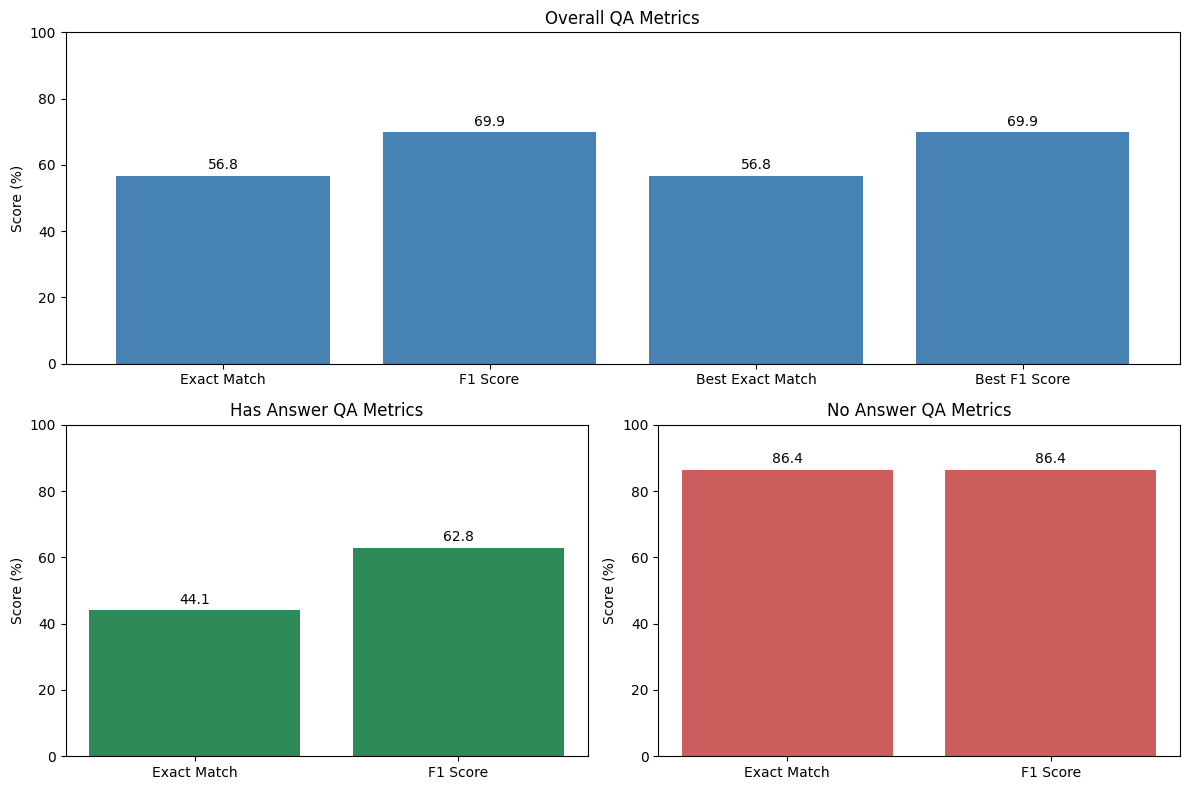

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))

gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, :])
overall_labels = ['Exact Match', 'F1 Score', 'Best Exact Match', 'Best F1 Score']
overall_scores = [results['exact'], results['f1'], results['best_exact'], results['best_f1']]
ax1.bar(overall_labels, overall_scores, color='steelblue')
ax1.set_ylim(0, 100)
ax1.set_title('Overall QA Metrics')
ax1.set_ylabel('Score (%)')
for i, v in enumerate(overall_scores):
    ax1.text(i, v + 2, f"{v:.1f}", ha='center')

ax2 = fig.add_subplot(gs[1, 0])
hasans_labels = ['Exact Match', 'F1 Score']
hasans_scores = [results['HasAns_exact'], results['HasAns_f1']]
ax2.bar(hasans_labels, hasans_scores, color='seagreen')
ax2.set_ylim(0, 100)
ax2.set_title('Has Answer QA Metrics')
ax2.set_ylabel('Score (%)')
for i, v in enumerate(hasans_scores):
    ax2.text(i, v + 2, f"{v:.1f}", ha='center')

ax3 = fig.add_subplot(gs[1, 1])
noans_labels = ['Exact Match', 'F1 Score']
noans_scores = [results['NoAns_exact'], results['NoAns_f1']]
ax3.bar(noans_labels, noans_scores, color='indianred')
ax3.set_ylim(0, 100)
ax3.set_title('No Answer QA Metrics')
ax3.set_ylabel('Score (%)')
for i, v in enumerate(noans_scores):
    ax3.text(i, v + 2, f"{v:.1f}", ha='center')

plt.tight_layout()
plt.show()


In [ ]:

metric = evaluate.load("squad_v2")

sample = random.choice(test_dataset)

#sample = test_dataset[15]

tokenized = tokenizer(
    sample["question"],
    sample["context"],
    return_offsets_mapping=True,
    return_tensors="pt",
    truncation=True,
    max_length=512
)
tokenized = tokenized.to(model.device)
offset_mapping = tokenized["offset_mapping"][0].cpu().numpy()
input_ids = tokenized["input_ids"][0].tolist()


with torch.no_grad():
    outputs = model(**{k: v for k, v in tokenized.items() if k in ["input_ids", "attention_mask"]})
    start_logits = outputs.start_logits[0].cpu().numpy()
    end_logits = outputs.end_logits[0].cpu().numpy()

cls_index = input_ids.index(tokenizer.cls_token_id)
cls_score = start_logits[cls_index] + end_logits[cls_index]

max_score = -float('inf')
best_answer = ""

for start_index in range(len(start_logits)):
    for end_index in range(start_index, min(start_index , len(end_logits))):
        if offset_mapping[start_index] is None or offset_mapping[end_index] is None:
            continue
        if tokenized.sequence_ids()[start_index] != 1 or tokenized.sequence_ids()[end_index] != 1:
            continue
        score = start_logits[start_index] + end_logits[end_index]
        if score > max_score:
            max_score = score
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            best_answer = sample["context"][start_char:end_char]

if cls_score > max_score :
    predicted_text = ""
    no_answer = True
else:
    predicted_text = best_answer.replace('\u200c', '').strip()
    no_answer = False

prediction = [{
    "id": str(sample["id"]),
    "prediction_text": predicted_text,
    "no_answer_probability": 1.0 if no_answer else 0.0,
}]

reference = [{
    "id": str(sample["id"]),
    "answers": sample["answers"]
}]

for ref in reference:
    ref['answers']['text'] = [ans.replace('\u200c', '') for ans in ref['answers']['text']]

results = metric.compute(predictions=prediction, references=reference)

print("\n--- RANDOM SAMPLE ---")
print(f"📌 Question: {sample['question']}")
print(f"📚 Context: {sample['context']}")
print(f"✅ Ground Truth Answer(s): {sample['answers']['text']}")
print(f"🤖 Model Prediction: {predicted_text if predicted_text else 'no answer'}")
#print(f"🚫 No Answer Detected: {no_answer}")
print(f"📈 SQuAD EM: {results['exact']}")
print(f"📉 SQuAD F1: {results['f1']:.2f}")

